#挂载google drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive 
!google-drive-ocamlfuse drive

In [0]:
!pwd
import os
os.chdir('./drive/COMP5318/comp5318 assignment2/')
!pwd
!ls

/content
/content/drive/COMP5318/comp5318 assignment2
comp5318_assignment2_color_CNN_2.ipynb	dataset     共享
comp5318_assignment2_color_LR.ipynb	drive
comp5318_assignment2_PCA_NN.ipynb	modelfor_0


#assignment

In [0]:
from __future__ import print_function
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio
from sklearn.decomposition import PCA
import numpy as np
import time
import gc
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

##PCA

In [0]:
#PCA part
train_path = "./dataset/train_32x32.mat"
data = scio.loadmat(train_path)

train_X = data["X"]
train_y = data["y"]
train_X = train_X.T

tmp = []
for row in train_X:
    tmp.append(row.flatten())
# release training set memory
train_X = None
gc.collect()

train_X = np.array(tmp)
tmp = None

train_X = train_X - train_X.mean(axis=0)
train_X.shape

# PCA decrease the dimension of the training set into d dimensions.
# d is a configurable variable (hyperparameter)
# In this case d = 50.
d = 50
pca = PCA(n_components=d)
start = time.time()
train_X = pca.fit(train_X).transform(train_X)

dataset = np.hstack((train_X,train_y))

enc = OneHotEncoder().fit(train_y.reshape(-1, 1))
train_y = enc.transform(train_y.reshape(-1, 1)).toarray()

print("training_data_shape=", train_X.shape)
print("training_labels_shape",train_y.shape)
end = time.time()
print("time consumption of preprocess : {}s".format(end-start))

training_data_shape= (73257, 50)
training_labels_shape (73257, 10)
time consumption of preprocess : 32.6540207863s


##绘制

In [0]:
#plot
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)

    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows * ncols)

    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat):

        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))

        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])

            # Display the image
        ax.imshow(images[i, :, :, 0], cmap='binary')

        # Annotate the image
        ax.set_title(title)

        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

##NN

In [0]:
#NN
def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer


In [0]:
fc_size = 500
class_num = 10

batch_size = 64


def train(train_data,train_labels,test_data,test_labels):
    data_size = len(train_data)
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=[None, 50], name='x')
    y_ = tf.placeholder(tf.float32, shape=[None, class_num], name='y_')
    y_true_cls = tf.argmax(y_, dimension=1)

    fc_1 = fc_layer(input=x,
                    layer_name="fc_1",
                    num_inputs=50,
                    num_outputs=fc_size,
                    relu=True)

    fc_1
    #
    fc_2 = fc_layer(input=fc_1,
                    layer_name="fc_2",
                    num_inputs=fc_size,
                    num_outputs=class_num,
                    relu=False)

    fc_2

    y = tf.nn.softmax(fc_2)
    y_pred_cls = tf.argmax(y, dimension=1)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_)
    cost = tf.reduce_mean(cross_entropy)

    train_step = tf.train.AdamOptimizer(0.001).minimize(cost)

    correct_prediction = tf.equal(y_pred_cls, y_true_cls)

    # Cast predictions to float and calculate the mean
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    keep_prob = tf.placeholder(tf.float32)

    with tf.Session()as sess:
        init_op=tf.initialize_all_variables()
        sess.run(init_op)
        step =5000

        for i in range(step):
            start = (i *batch_size) % data_size
            end = min(start+batch_size,data_size)
            sess.run(train_step,feed_dict={x:train_data[start:end],y_:train_labels[start:end]})

            if i%100==0:
                total_cross_entropy = sess.run(cross_entropy, feed_dict={x:train_data,y_:train_labels})

                print(" total_cross_entropy",total_cross_entropy)

        test_accuracy = sess.run(accuracy, {x:test_data, y_: test_labels, keep_prob: 1.0})
        test_pred = sess.run(y_pred_cls, {x:test_data, y_: test_labels, keep_prob: 1.0})
    print(" test_accuracy", test_accuracy)

    return test_pred


##分割

In [0]:
def train_test_split_10(train_X, train_y, k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples // 10) * k
    end_jump = (num_of_examples // 10) * (k + 1)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(train_X)):
        if i <= start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i > end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train,  y_train,X_test, y_test

train_data,train_labels,test_data,test_labels=train_test_split_10(train_X, train_y,0)
train_data_img,_,test_data_img,_=train_test_split_10(data["X"].transpose((3, 0, 1, 2)), data["y"],0)

##训练

In [0]:
test_pred=train(train_data,train_labels,test_data,test_labels)

 total_cross_entropy [134.5053  516.1509  138.22266 ...  62.39968 139.85925 685.59937]
 total_cross_entropy [ 54.177353  52.503532  10.593472 ...  19.431011 100.541626 124.228966]
 total_cross_entropy [45.08589  54.864845 33.230812 ... 26.07391  35.942474 63.522858]
 total_cross_entropy [ 0.18552874 32.879173    2.8727813  ...  0.         68.09406
  8.224093  ]
 total_cross_entropy [24.110596 73.03185   0.       ...  0.       36.575302 75.21973 ]
 total_cross_entropy [2.5960413e-04 3.0721306e+01 2.3841855e-07 ... 0.0000000e+00 1.7390825e+01
 4.1756866e+01]
 total_cross_entropy [3.3854863e-05 1.5987801e+01 0.0000000e+00 ... 0.0000000e+00 3.3417019e+01
 1.1504069e+01]
 total_cross_entropy [1.1920928e-07 2.0577982e+01 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 9.6094574e+01]
 total_cross_entropy [2.9230947e+00 8.5830325e-06 1.1378816e+00 ... 0.0000000e+00 1.1920928e-07
 0.0000000e+00]
 total_cross_entropy [3.0159496e-05 0.0000000e+00 0.0000000e+00 ... 7.3821988e+00 0.0000000e+00
 2.78

 total_cross_entropy [6.325796   0.         0.         ... 0.         0.10230924 0.        ]
 total_cross_entropy [1.6544945e+01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 1.3898837e-04]
 total_cross_entropy [8.3446469e-07 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.0652855e+01
 9.5367386e-07]
 total_cross_entropy [1.3310243e-01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.1801650e-05
 0.0000000e+00]
 total_cross_entropy [5.4851317  0.         0.         ... 0.         0.01694217 0.        ]
 total_cross_entropy [3.4570635e-06 0.0000000e+00 8.0654323e-01 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 test_accuracy 0.7497611


##结果

[8 1 2 ... 8 0 0]


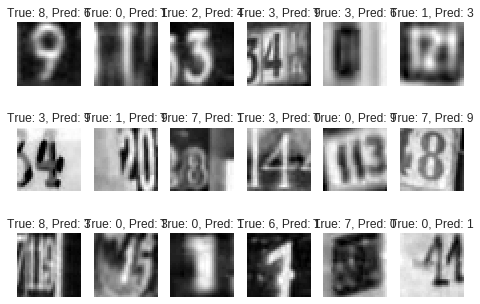

In [0]:
incorrect = test_pred != np.argmax(test_labels, axis=1)
print(test_pred)
temp = test_data_img


# Select the incorrectly classified examples
images = temp[incorrect]
cls_true = test_labels[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

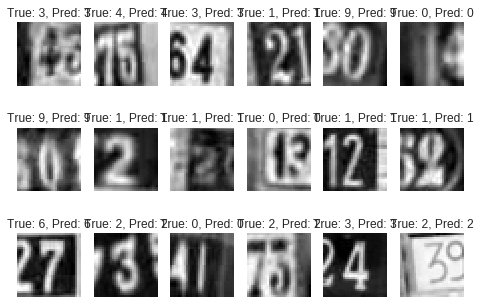

In [0]:
correct = np.invert(incorrect)

# Select the correctly classified examples
images = temp[correct]
cls_true = test_labels[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

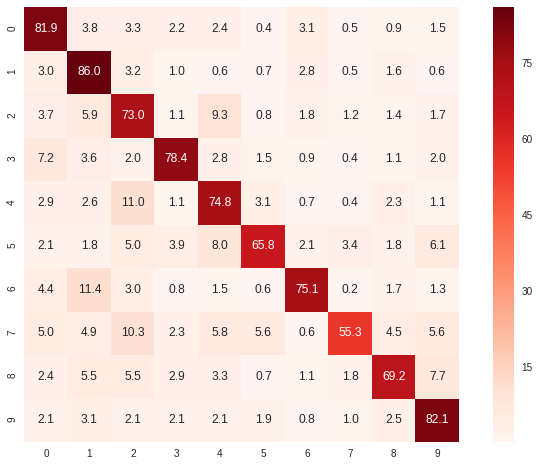

In [0]:
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(test_labels, axis=1), y_pred=test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);